##1. Import **Libraries**

In [ ]:
import numpy as np
import pandas as pd
import spacy
import pickle
import itertools
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

##2. Data Downloading

In [ ]:
# To upload the file "kaggle.json" 
# See "https://www.kaggle.com/general/74235"
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jarupula/yahoo-answers-dataset

In [ ]:
! unzip yahoo-answers-dataset.zip -d data

In [ ]:
# I used Google Drive to store the training data and other variables
from google.colab import drive
drive.mount('/content/drive')

##3. Data Visualization

In [ ]:
df_classes = pd.read_csv("/content/data/classes.txt",header=None,names=["classes"])
df_classes.index = np.arange(1, len(df_classes)+1)

In [ ]:
df_classes

,classes
1,Society & Culture
2,Science & Mathematics
3,Health
4,Education & Reference
5,Computers & Internet
6,Sports
7,Business & Finance
8,Entertainment & Music
9,Family & Relationships
10,Politics & Government


In [ ]:
df = pd.read_csv("/content/data/train.csv", header=None, names=['label','question_title','question_content','best_answer'])
df.head()

,label,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [ ]:
df.shape

(1400000, 4)

In [ ]:
# Removing objets which have missing values
df.dropna(subset = ["best_answer"], inplace=True)
df.dropna(subset = ["question_title"], inplace=True)
df = df.reset_index()
df.shape

(1375421, 5)

In [ ]:
# Renameing the labels
for idx,cls in enumerate(df_classes["classes"],start=1):
  df.loc[df["label"] == idx, "label"] = cls

In [ ]:
df = df.drop(["index", "question_content"], axis = 1)
df.head()

,label,question_title,best_answer
0,Computers & Internet,why doesn't an optical mouse work on a glass t...,Optical mice use an LED and a camera to rapidl...
1,Sports,What is the best off-road motorcycle trail ?,i hear that the mojave road is amazing!<br />\...
2,Health,What is Trans Fat? How to reduce that?,Trans fats occur in manufactured foods during ...
3,Business & Finance,How many planes Fedex has?,according to the www.fedex.com web site:\nAir ...
4,Business & Finance,"In the san francisco bay area, does it make se...",renting vs buying depends on your goals. <br /...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


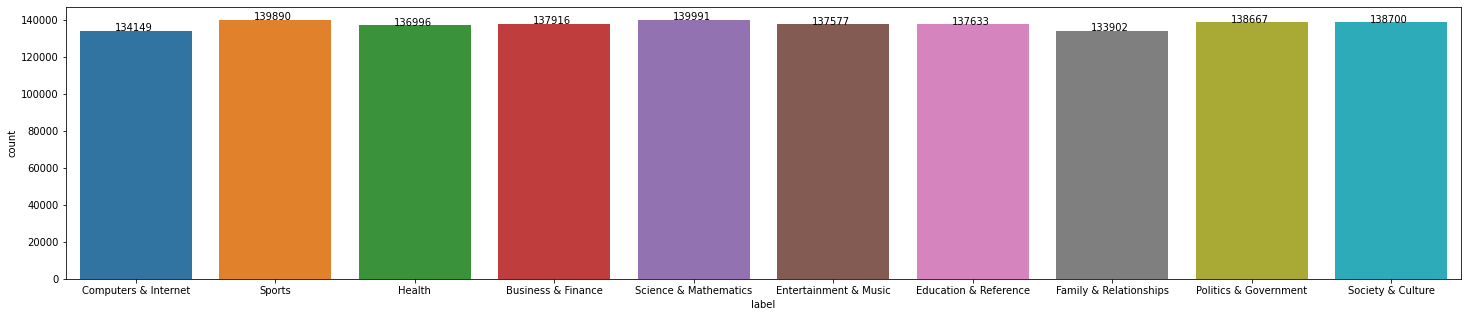

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,5))
ax = sns.countplot(df["label"])
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

##4. Preprocessing Data

In [11]:
# # !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [ ]:
def clean_data(questions):
  cleaned_data = []
  i=0
  for question  in questions:
      doc = nlp(question)
      lst = [str(token.lemma_).lower() for token in doc if not (token.is_stop or \
                                                                token.is_punct or \
                                                                len(token)<3)]
      cleaned_data.append(lst)
      i += 1
      if i%200000==0:
        print(f"{i} questions were cleaned")
      
  print(f"{i} questions were cleaned")   
  return cleaned_data

In [ ]:
# Due to the size of the data, this cell takes about two hours to be run
cleaned_data = clean_data(df["question_title"])

b_file = open("/content/drive/MyDrive/yahoo-answers-dataset/cleaned_data.pkl", "wb")
pickle.dump(cleaned_data, b_file)
b_file.close()

In [ ]:
"""
dic = {
    "Society & Culture":     [(q1,ans1),(q2,ans2),....]
    "Science & Mathematics": [(q1,ans1),(q2,ans2),....]
    "Health":                [(q1,ans1),(q2,ans2),....]
    .
    .
    .
    "Politics & Government": [(q1,ans1),(q2,ans2),....]
  }

"""

def build_dic(df,cleaned_data, classes):
  dic = {}
  for cls in classes:
    dic[cls] = []
  for i in range(df.shape[0]):
    raw = df.loc[i]
    dic[raw.label].append((cleaned_data[i], raw.best_answer))
  return dic

In [ ]:
dic = build_dic(df,cleaned_data, classes=df_classes["classes"])

a_file = open("/content/drive/MyDrive/yahoo-answers-dataset/dic.pkl", "wb")
pickle.dump(dic, a_file)
a_file.close()

In [ ]:
def encoding_data(cleaned_data, labels, classes):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(cleaned_data)

    # word_index is a dictionary contains indeces for the words like {'for': 8, 'is': 9, 'me': 10, ...}
    word_index = tokenizer.word_index

    # train_sequences is vectors where each vector represents a sentence
    data_sequences = tokenizer.texts_to_sequences(cleaned_data)
    data_sequences = pad_sequences(data_sequences, maxlen=10, padding="post")

    # Convert our labels into one-hot encoded
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(classes)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(integer_encoded)

    data_label_encoded = label_encoder.transform(labels)
    data_label_encoded = data_label_encoded.reshape(len(data_label_encoded), 1)
    data_label = onehot_encoder.transform(data_label_encoded)


    with open("/content/drive/MyDrive/yahoo-answers-dataset/tokenizer.pkl","wb") as file:
        pickle.dump(tokenizer,file)

    with open("/content/drive/MyDrive/yahoo-answers-dataset/label_encoder.pkl","wb") as file:
        pickle.dump(label_encoder,file)

    return data_sequences, data_label, word_index
#------------------------------------------------------------------#
data_sequences, data_label, word_index = encoding_data(cleaned_data, df["label"], classes=df_classes["classes"])

with open("/content/drive/MyDrive/yahoo-answers-dataset/data_sequences.pkl","wb") as file:
    pickle.dump(data_sequences,file)
with open("/content/drive/MyDrive/yahoo-answers-dataset/data_label.pkl","wb") as file:
    pickle.dump(data_label,file)
with open("/content/drive/MyDrive/yahoo-answers-dataset/word_index.pkl","wb") as file:
    pickle.dump(word_index,file)

##5. Importing GloVe dataset

In [ ]:
!pip install wget
import wget
url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

def GloVe(data = 'glove.6B.100d.txt'):

  embeddings_index={}
  with open(data, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
  return embeddings_index
#--------------------------------------------------------------------------------------------#
def embeddingWights(word_index, max_num_words=500000):
  embeddings_index = GloVe()
  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std()

  num_words = min(max_num_words, len(word_index))+1

  embedding_dim=len(embeddings_index['the'])

  embedding_wights = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))

  for word, i in word_index.items():
      if i >= max_num_words:
          break
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_wights[i] = embedding_vector
  
  return embedding_wights, num_words

In [ ]:
embedding_wights, num_words = embeddingWights(word_index)

a_file = open("/content/drive/MyDrive/yahoo-answers-dataset/embedding_wights.pkl", "wb")
pickle.dump(embedding_wights, a_file)
a_file.close()

a_file = open("/content/drive/MyDrive/yahoo-answers-dataset/num_words.pkl", "wb")
pickle.dump(num_words, a_file)
a_file.close()

In [ ]:
# Importing all the variables from Google Drive
with open('/content/drive/MyDrive/yahoo-answers-dataset/cleaned_data.pkl','rb') as file:
  cleaned_data = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/data_label.pkl','rb') as file:
  data_label = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/data_sequences.pkl','rb') as file:
  data_sequences = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/dic.pkl','rb') as file:
  dic = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/label_encoder.pkl','rb') as file:
  label_encoder = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/num_words.pkl','rb') as file:
  num_words = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/tokenizer.pkl','rb') as file:
  tokenizer = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/word_index.pkl','rb') as file:
  word_index = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/embedding_wights.pkl','rb') as file:
  embedding_wights = pickle.load(file)

##6. Splitting the Data

In [ ]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(data_sequences, data_label,test_size = 0.3, stratify=data_label)
test_data, val_data, test_labels, val_labels = train_test_split(val_test_data, val_test_labels, test_size = 0.5, stratify=val_test_labels)

##7. Model Preparation and Training

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, trainable=True, input_length=10, weights=[embedding_wights]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), 'concat'))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss ='categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

In [ ]:
print(model.summary())

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, 10, 100)           28182700  

                                                                 

 bidirectional (Bidirectiona  (None, 10, 512)          731136    

 l)                                                              

                                                                 

 dropout (Dropout)           (None, 10, 512)           0         

                                                                 

 lstm_1 (LSTM)               (None, 10, 128)           328192    

                                                                 

 dropout_1 (Dropout)         (None, 10, 128)           0         

                                                                 

 lstm_2 (LSTM)               (None, 64)                49408     

                                        

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose = 1, factor = 0.1, min_delta=0.001, min_lr = 0.00001)

history = model.fit(train_data, train_labels, epochs = 20,
          batch_size = 2048, shuffle=True,
          validation_data=[val_data, val_labels],
          callbacks=[reduce_lr, stopping])

model.save('/content/drive/MyDrive/yahoo-answers-dataset/intents.h5')

Epoch 1/20

471/471 [==============================] - 140s 254ms/step - loss: 1.3911 - accuracy: 0.5605 - val_loss: 1.0947 - val_accuracy: 0.6551 - lr: 0.0010

Epoch 2/20

471/471 [==============================] - 111s 236ms/step - loss: 1.0989 - accuracy: 0.6593 - val_loss: 1.0357 - val_accuracy: 0.6720 - lr: 0.0010

Epoch 3/20

471/471 [==============================] - 126s 268ms/step - loss: 1.0276 - accuracy: 0.6803 - val_loss: 1.0179 - val_accuracy: 0.6783 - lr: 0.0010

Epoch 4/20

471/471 [==============================] - 124s 264ms/step - loss: 0.9775 - accuracy: 0.6954 - val_loss: 1.0132 - val_accuracy: 0.6804 - lr: 0.0010

Epoch 5/20

471/471 [==============================] - ETA: 0s - loss: 0.9330 - accuracy: 0.7095

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

471/471 [==============================] - 125s 266ms/step - loss: 0.9330 - accuracy: 0.7095 - val_loss: 1.0195 - val_accuracy: 0.6803 - lr: 0.0010

Epoch 6/20

471/471 [==========

In [ ]:
model.evaluate(test_data, test_labels)

6448/6448 [==============================] - 109s 17ms/step - loss: 1.0352 - accuracy: 0.6807


[1.0351841449737549, 0.6807181239128113]

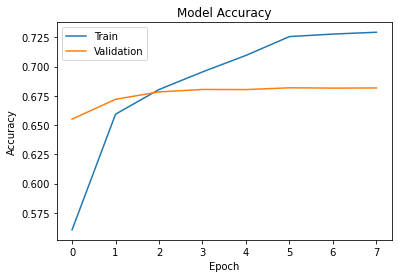

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

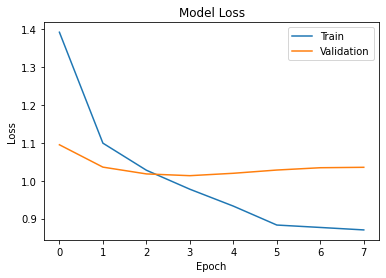

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

##8. Engine

In [29]:
def engine(model, tokenizer, label_encoder, dic):

  question = input('Enter a question: ')
  while True:
    if question == "exit":
      break
    doc = nlp(question)
    lst = []
    lst = [str(token.lemma_).lower() for token in doc if not (token.is_stop or \
                                                                token.is_punct or \
                                                                len(token)<3)]
    test_keras = tokenizer.texts_to_sequences(lst)
    test_keras = [j for i in test_keras for j in i]
    test_keras_sequence = pad_sequences([test_keras], maxlen=10, padding='post')
    pred = model.predict(test_keras_sequence, verbose=0)

    L = label_encoder.inverse_transform(np.argmax(pred,1))[0]

    A = test_keras_sequence.reshape(1,-1)
    lst = []
    for tup in dic[L]:
      B = tup[0]
      B = tokenizer.texts_to_sequences(B)
      B = [j for i in B for j in i]
      B = pad_sequences([B], maxlen=10, padding='post')
      B = B.reshape(1,-1)
      s = cosine_similarity(A,B)
      lst.append(s)
    max_index = np.argmax(lst)
    answer = dic[L][max_index][1]

    print(f"Our Answer is: {answer}")
    question = input('Enter a question: ')

In [9]:
model = load_model('/content/drive/MyDrive/yahoo-answers-dataset/intents.h5')

with open('/content/drive/MyDrive/yahoo-answers-dataset/tokenizer.pkl','rb') as file:
  tokenizer = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/label_encoder.pkl','rb') as file:
  label_encoder = pickle.load(file)

with open('/content/drive/MyDrive/yahoo-answers-dataset/dic.pkl','rb') as file:
  dic = pickle.load(file)

In [31]:
engine(model, tokenizer, label_encoder, dic)

Enter a question: What is Trans Fat?

Our Answer is: Definitions of trans fat on the Web:\n\nvegetable oil that has been treated with hydrogen in order to make it more solid and give it a longer shelf life.\nuuhsc.utah.edu/healthinfo/adult/cardiac/glossary.htm\n\nTrans fat is a type of processed fat that does not occur in nature (also called hydrogenated or partially hydrogenated fat/oil). Used in baked goods like doughnuts, breads, crackers, potato chips, cookies and many other processed food products like margarine and salad dressings.\nwww.1st-for-health.com/low-carb/article2.htm\n\nA trans fatty acid (commonly shortened to trans fat) is an unsaturated fatty acid whose molecules contain trans double bonds between carbon atoms, which makes the molecules less kinked compared to those of 'cis fat'. Research suggests a correlation between diets high in trans fats and diseases like atherosclerosis and coronary heart disease. The National Academy of Sciences recommended in 2002 that dieta